In [ ]:
import yfinance as yahooFinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date

In [9]:
daily_bitcoin = yahooFinance.download("BTC-USD", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')


[*********************100%%**********************]  1 of 1 completed


In [33]:
daily_apple = yahooFinance.download("AAPL", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_appleBefore = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [45]:
appleDiff = daily_apple['Close'].diff()
appleDiff.dropna(inplace=True)


In [10]:
daily_bitcoin.index



DatetimeIndex(['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04',
               '2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08',
               '2023-09-09', '2023-09-10',
               ...
               '2024-08-22', '2024-08-23', '2024-08-24', '2024-08-25',
               '2024-08-26', '2024-08-27', '2024-08-28', '2024-08-29',
               '2024-08-30', '2024-08-31'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

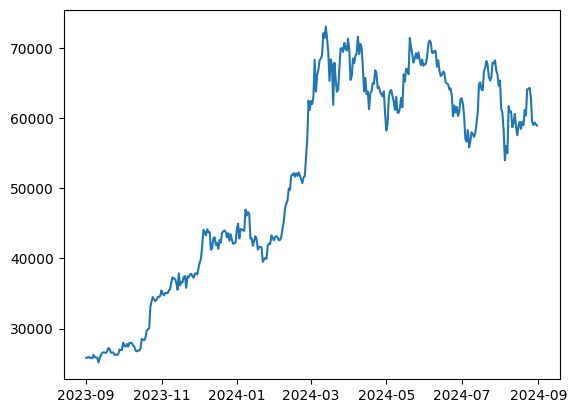

In [12]:
plt.plot(daily_bitcoin['Close'])



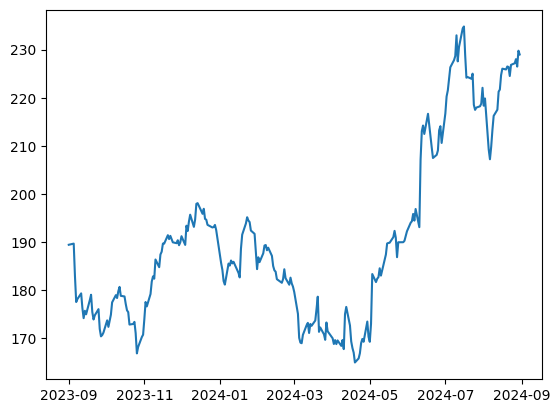

In [13]:
plt.plot(daily_apple['Close'])

In [14]:
#https://mayerkrebs.com/relative-strength-index-rsi-in-python/
#RSI
def rsi(closeArray, period=14):
    dayDiff = closeArray.diff()
    dayDiff.dropna(inplace=True)
    diffPos = dayDiff.copy()
    diffNeg = dayDiff.copy()

    diffPos[diffPos<0] = 0
    diffNeg[diffNeg>0] = 0
    avgPos = diffPos.rolling(period).mean()
    avgNeg = diffNeg.rolling(period).mean().abs()

    rsi = 100* avgPos / (avgPos + avgNeg)
    rsi.head(20)
    return rsi


In [34]:
#https://dayanand-shah.medium.com/exponential-moving-average-and-implementation-with-python-1890d1b880e6
#EMA
##def ema(closeArray, period):
  #  ema = closeArray.ewm(span=period, adjust=False).mean()
   # return ema



    #définition d'un exponential movind average sur un 1d array

def ema(closeArray, period):
    
    ema = np.zeros_like(closeArray)
    
    alpha = 2 /(period + 1)
    
    for i in range(period, len(closeArray)):
        
        if np.isnan(closeArray[i]) :
            
            continue
        
        else:
            
            ema[i] = alpha*closeArray[i] + (1 - alpha)*ema[i-1]
        
        
    ema[ema==0]=np.nan
    
    return ema


    
def PEMA(closeArray,period):
    MA1 = ema(closeArray,period)
    MA2 = ema(MA1,period)
    MA3 = ema(MA2,period)
    MA4 = ema(MA3,period)
    MA5 = ema(MA4,period)
    MA6 = ema(MA5,period)
    MA7 = ema(MA6,period)
    MA8 = ema(MA7,period)
    PEMA = 8*MA1 - 28*MA2 + 56*MA3 -70*MA4 + 56*MA5 - 28*MA6 + 8*MA7 - MA8
    return PEMA



    

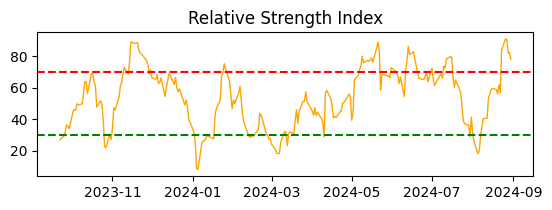

In [19]:
appleRSI = rsi(daily_apple['Close'])

ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(appleRSI, color='orange', linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')


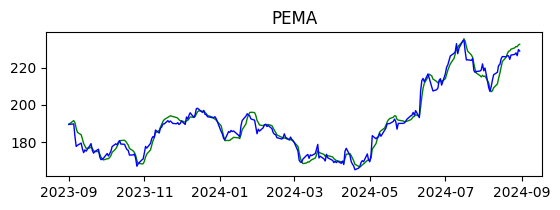

In [44]:
applePEMA = PEMA(daily_appleBefore['Close'].to_numpy(), 34)

ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# Second chart
# Plot the EMA
ax2.set_title('PEMA')
applePEMADate =  applePEMA[len(applePEMA) - len(daily_apple.index):]
ax2.plot(daily_apple.index, applePEMADate, color='green', linewidth=1)
ax2.plot(daily_apple.index, daily_apple['Close'], color='blue', linewidth=1)

In [135]:
def pemaSignals(pema):
    
    buySignal = np.zeros_like(pema)
    sellSignal = np.zeros_like(pema)
    deltaPEMA = np.diff(pema)
    
    for i in range(len(deltaPEMA)):
        if i-2 > 0:
            if deltaPEMA[i - 1] < 0. and deltaPEMA[i] > 0. :
                buySignal[i] = 1
            else:
                   buySignal[i] = np.nan
        else:
            buySignal[i] = np.nan
    
    for i in range(len(deltaPEMA)):
        if i-2 > 0:
            if deltaPEMA[i - 1] > 0. and deltaPEMA[i] < 0. :
                sellSignal[i] = 1
            else:
                   sellSignal[i] = np.nan
        else:
            sellSignal[i] = np.nan
        
    buySignal[len(buySignal)-1] = np.nan
    sellSignal[len(buySignal)-1] = np.nan

    return buySignal, sellSignal


In [136]:
def moneyMade(buySignals, sellSignals, stockPrices, titre):
    cashAmount = 0
    hasInvested = False
    initialBoughtAction = 0
    stockAmount = 1.

    
    for i in range(len(stockPrices)):
        if not hasInvested:
            if(buySignals[i] == 1):
                hasInvested = True
                initialBoughtAction = stockPrices.iloc[i]
                cashAmount = initialBoughtAction
        
        else:   
            if(buySignals[i] == 1):
                stockAmount = cashAmount/stockPrices.iloc[i]

            if(sellSignals[i] == 1):
                cashAmount = stockAmount*stockPrices.iloc[i]

    profit = 100*(cashAmount / initialBoughtAction - 1)
    buy_and_hold = 100*(stockPrices.iloc[i-1]/stockPrices.iloc[0] - 1)
    print(titre +  ' Profit :', profit, '%')
    print('Acheter action Profit: ', buy_and_hold, '%')
    return
    

In [163]:

def pemaResult(daily, dailyBefore, pemaPeriod, titre):
    dailyPemaLong = PEMA(dailyBefore['Close'].to_numpy(), pemaPeriod)
    dailyPema = dailyPemaLong[len(dailyPemaLong) - len(daily.index):]

    diffPEMA = np.append(np.diff(dailyPema), 0)
    buySignal, sellSignal = pemaSignals(dailyPema)
    
    fig, ax = plt.subplots()

    priceArray = daily['Close'].to_numpy()
    lowest_point = np.min(priceArray)
    max_point = np.max(priceArray)
    

    ax.plot(daily.index, buySignal*daily['Close'], '*g')
    ax.plot(daily.index, sellSignal*daily['Close'], '*r')
    ax.plot(daily.index, dailyPema, color='purple', linewidth=1)
    ax.plot(daily.index, daily['Close'])
    plt.title(titre)
    ax.autoscale_view()

    
   # ax.fill_between(daily.index, lowest_point, max_point, where= diffPEMA >= 0, facecolor = 'green', alpha = .2)
   # ax.fill_between(daily.index, lowest_point, max_point, where= diffPEMA < 0, facecolor = 'red', alpha = .2)

    buySignalPd = pd.Series(list(buySignal), index=list(range(0,len(daily.index))))
    sellSignalPd = pd.Series(list(sellSignal), index=list(range(0,len(daily.index))))

    begi = 0
    for i in range(len(daily.index)):
        if(begi == 0):
            if(buySignal[i]==1):
                ax.fill_between(daily.index[0:i], max_point, lowest_point, facecolor = 'green', alpha = .2)
                begi = i
        else:
            if(sellSignal[i] == 1):
                ax.fill_between(daily.index[begi-1:i], max_point, lowest_point, facecolor = 'green', alpha = .2)
                begi = i
                
            if(buySignal[i] ==1):
                ax.fill_between(daily.index[begi-1:i], max_point, lowest_point, facecolor = 'red', alpha = .2)
                begi = i

    
    moneyMade(buySignal, sellSignal, daily['Close'], titre)
    return


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Apple PEMA 9 jours Profit : 269.06615200065744 %
Acheter action Profit:  21.286807317163326 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Apple PEMA 20 jours Profit : 210.03387693271938 %
Acheter action Profit:  21.286807317163326 %
Apple PEMA 34 jours Profit : 169.69321678636487 %
Acheter action Profit:  21.286807317163326 %


Banque Nationale PEMA 9 jour Profit : 183.27875324138904 %
Acheter action Profit:  30.691403445980825 %
Banque Nationale PEMA 20 jours Profit : 148.1665894995443 %
Acheter action Profit:  30.691403445980825 %
Banque Nationale PEMA 34 jours Profit : 99.06549525180748 %
Acheter action Profit:  30.691403445980825 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Forex PEMA 9 jours Profit : 34.04467585907325 %
Acheter action Profit:  0.24263518625704528 %
Forex PEMA 20 jours Profit : 27.707741929581342 %
Acheter action Profit:  0.24263518625704528 %
Forex PEMA 34 jours Profit : 18.876432245798203 %
Acheter action Profit:  0.24263518625704528 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


SPX PEMA 9 jours Profit : 124.9412383793572 %
Acheter action Profit:  23.83181465733637 %
SPX PEMA 20 jours Profit : 113.32174561176328 %
Acheter action Profit:  23.83181465733637 %
SPX PEMA 34 jours Profit : 87.6357232792673 %
Acheter action Profit:  23.83181465733637 %


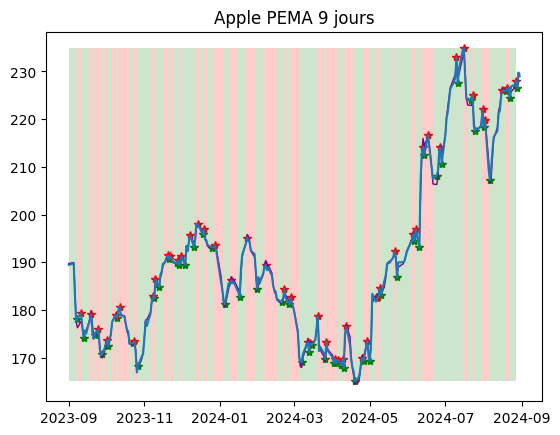

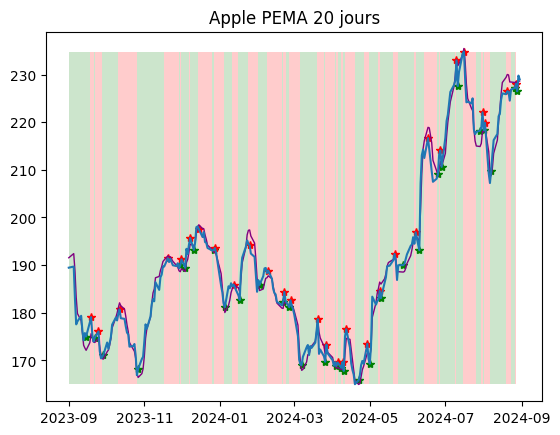

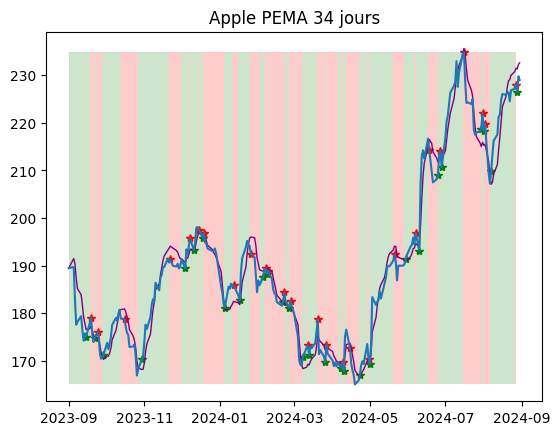

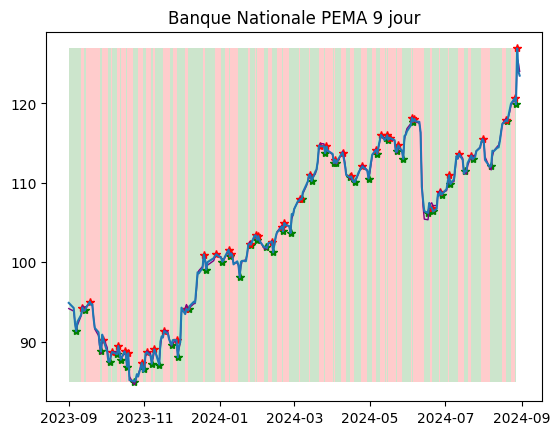

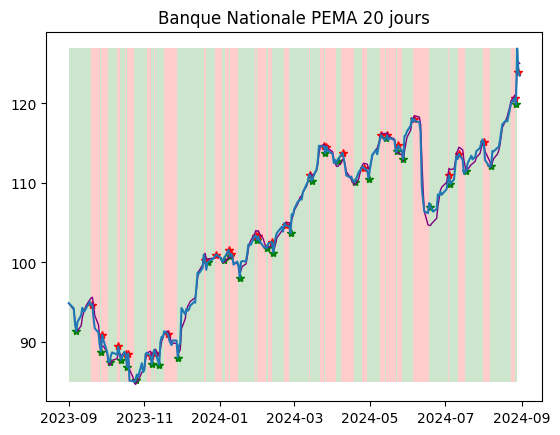

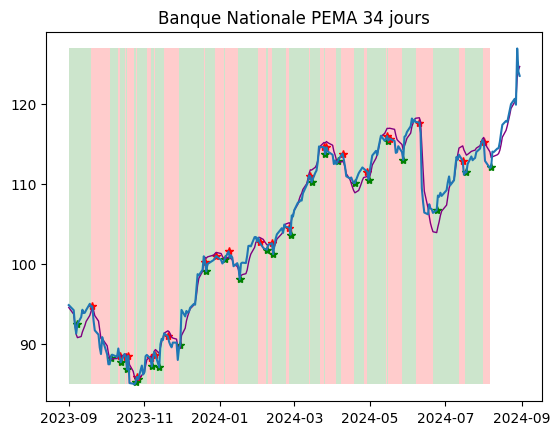

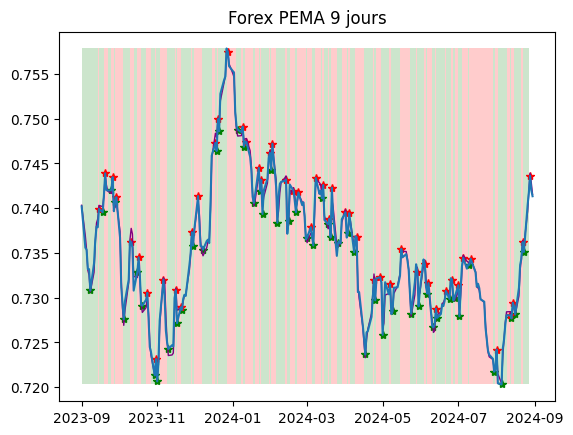

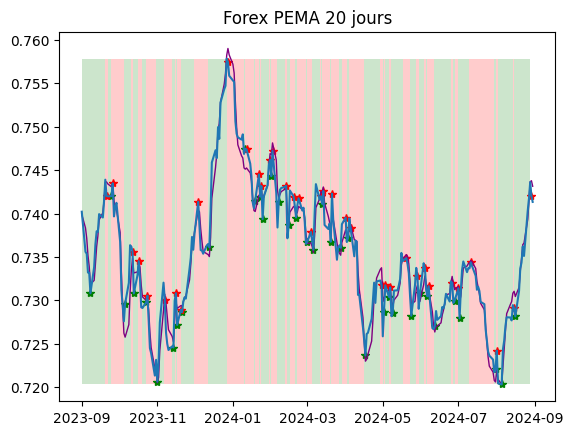

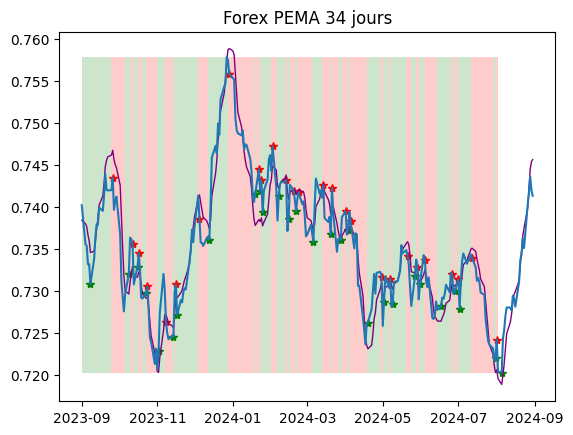

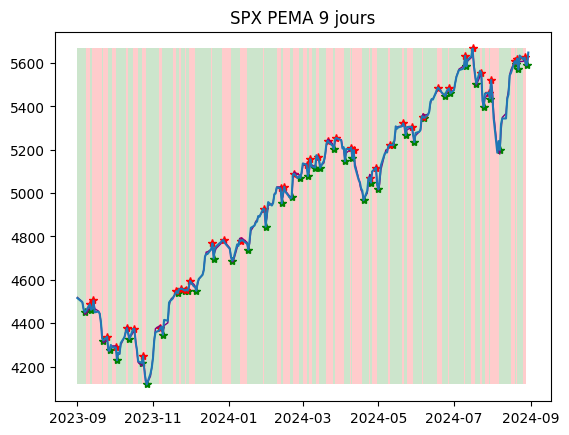

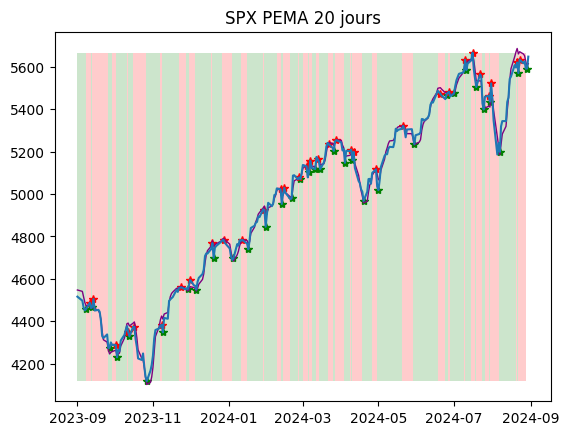

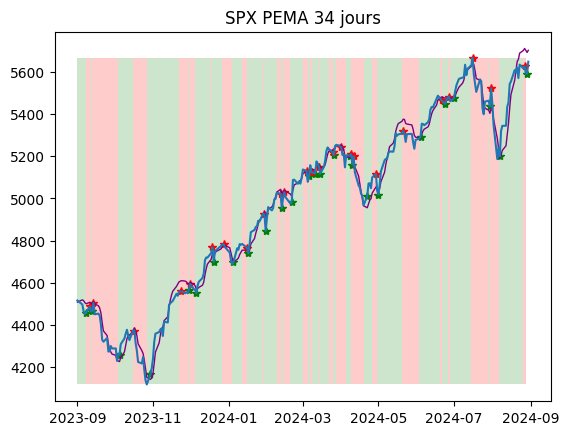

In [164]:
#Yearly
#Apple
daily_apple = yahooFinance.download("AAPL", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_appleBeforePEMA = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_apple, daily_appleBeforePEMA, 9, 'Apple PEMA 9 jours')
pemaResult(daily_apple, daily_appleBeforePEMA, 20, 'Apple PEMA 20 jours')
pemaResult(daily_apple, daily_appleBeforePEMA, 34, 'Apple PEMA 34 jours')

#BNO
daily_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 9, 'Banque Nationale PEMA 9 jour')
pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 20, 'Banque Nationale PEMA 20 jours')
pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 34, 'Banque Nationale PEMA 34 jours')

#FOREX
daily_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_cadusd, daily_cadusdBefore, 9, 'Forex PEMA 9 jours')
pemaResult(daily_cadusd, daily_cadusdBefore, 20, 'Forex PEMA 20 jours')
pemaResult(daily_cadusd, daily_cadusdBefore, 34, 'Forex PEMA 34 jours')

#SP500
daily_sp500 = yahooFinance.download("^GSPC", start = datetime(2023,9,1), end = datetime(2024,9,1), interval = '1d')
daily_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_sp500, daily_sp500Before, 9, 'SPX PEMA 9 jours')
pemaResult(daily_sp500, daily_sp500Before, 20, 'SPX PEMA 20 jours')
pemaResult(daily_sp500, daily_sp500Before, 34, 'SPX PEMA 34 jours')







[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Apple PEMA 9 jours Profit : 54.28263944920133 %
Acheter action Profit:  18.430136953982988 %
Apple PEMA 20 jours Profit : 45.594910344516215 %
Acheter action Profit:  18.430136953982988 %
Apple PEMA 34 jours Profit : 40.7069169610335 %
Acheter action Profit:  18.430136953982988 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Banque Nationale PEMA 9 jour Profit : 29.124764968176 %
Acheter action Profit:  5.802050536537839 %
Banque Nationale PEMA 20 jours Profit : 23.419970502194154 %
Acheter action Profit:  5.802050536537839 %
Banque Nationale PEMA 34 jours Profit : 9.340556736864357 %
Acheter action Profit:  5.802050536537839 %



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Forex PEMA 9 jours Profit : 6.435955228224222 %
Acheter action Profit:  1.0528961238872814 %
Forex PEMA 20 jours Profit : 5.46151637779988 %
Acheter action Profit:  1.0528961238872814 %
Forex PEMA 34 jours Profit : 1.8639863806474422 %
Acheter action Profit:  1.0528961238872814 %



[*********************100%%**********************]  1 of 1 completed


SPX PEMA 9 jours Profit : 22.71136715354509 %
Acheter action Profit:  5.840179889787844 %
SPX PEMA 20 jours Profit : 18.928377638438242 %
Acheter action Profit:  5.840179889787844 %
SPX PEMA 34 jours Profit : 14.495019301750101 %
Acheter action Profit:  5.840179889787844 %


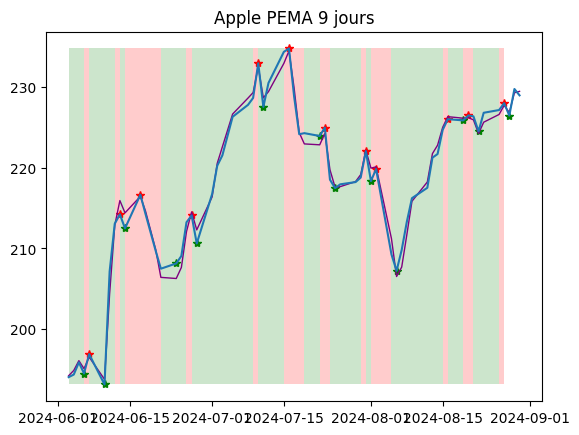

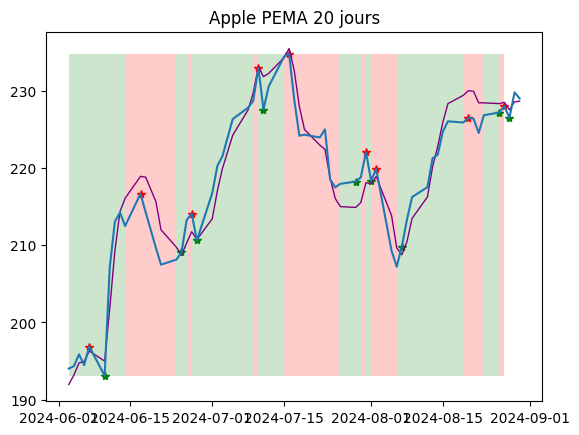

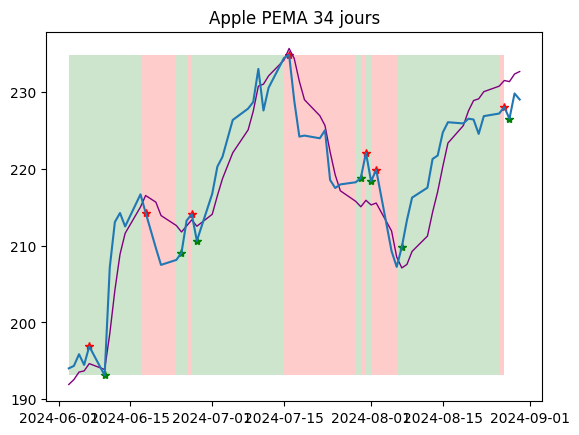

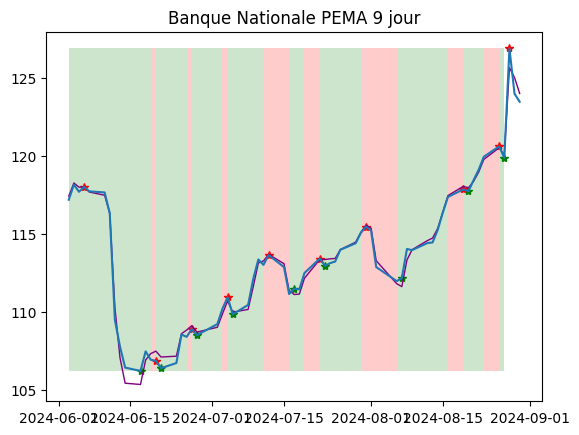

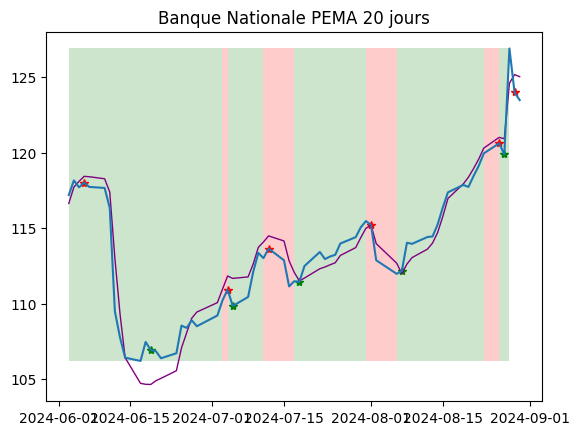

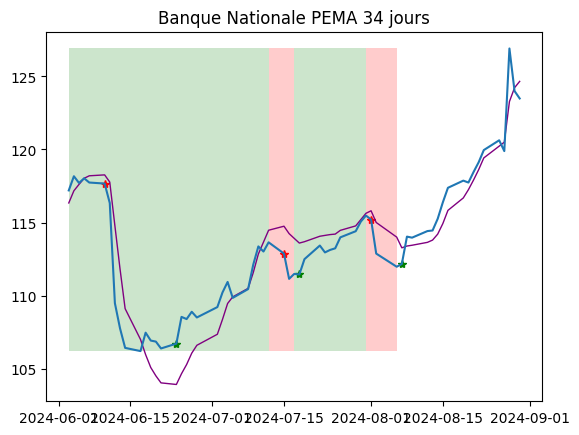

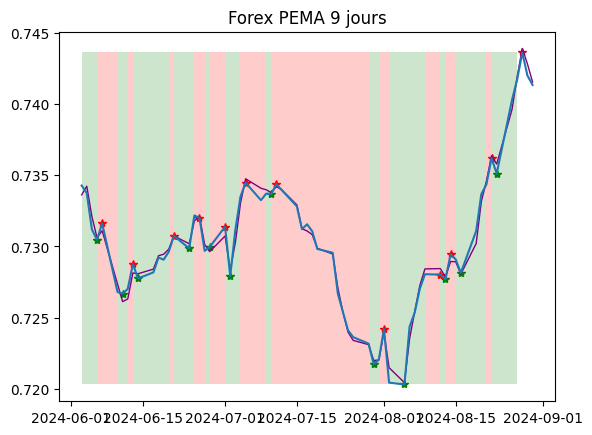

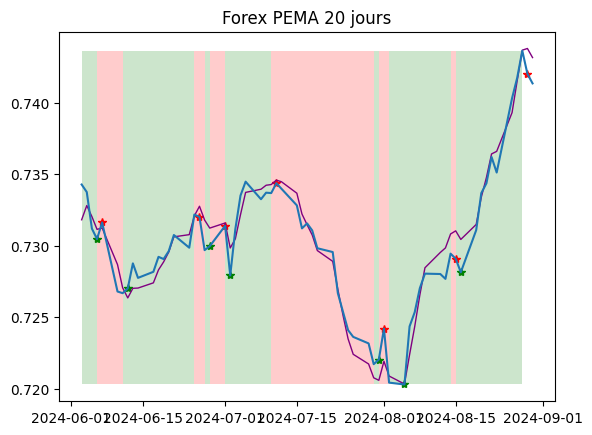

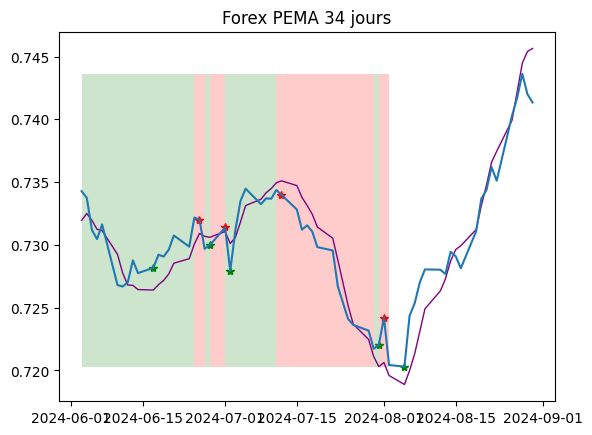

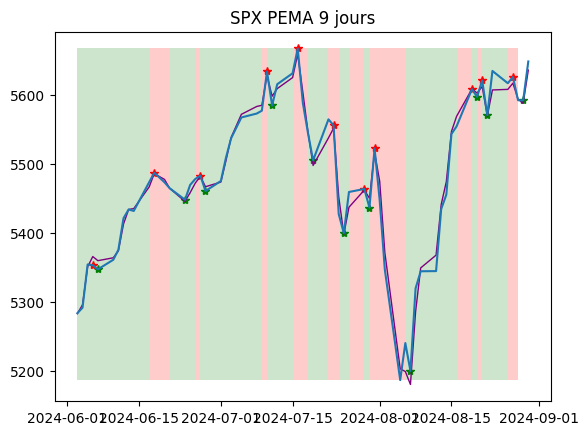

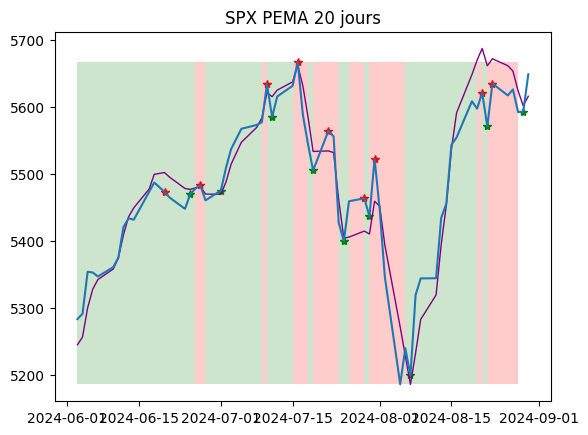

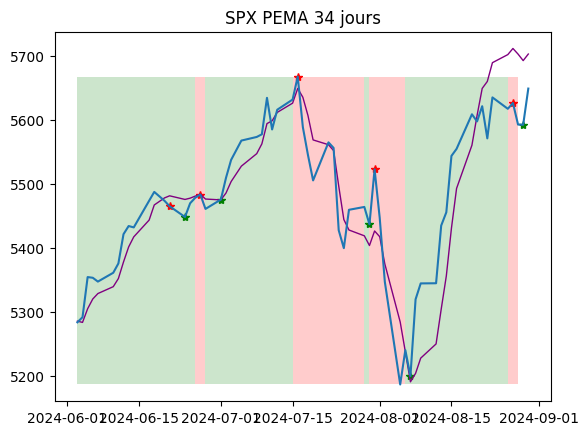

In [165]:
#3 mois
#Apple
daily_apple = yahooFinance.download("AAPL", start = datetime(2024,6,1), end = datetime(2024,9,1), interval = '1d')
daily_appleBeforePEMA = yahooFinance.download("AAPL", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_apple, daily_appleBeforePEMA, 9, 'Apple PEMA 9 jours')
pemaResult(daily_apple, daily_appleBeforePEMA, 20, 'Apple PEMA 20 jours')
pemaResult(daily_apple, daily_appleBeforePEMA, 34, 'Apple PEMA 34 jours')

#BNO
daily_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2024,6,1), end = datetime(2024,9,1), interval = '1d')
daily_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 9, 'Banque Nationale PEMA 9 jour')
pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 20, 'Banque Nationale PEMA 20 jours')
pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 34, 'Banque Nationale PEMA 34 jours')

#FOREX
daily_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2024,6,1), end = datetime(2024,9,1), interval = '1d')
daily_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_cadusd, daily_cadusdBefore, 9, 'Forex PEMA 9 jours')
pemaResult(daily_cadusd, daily_cadusdBefore, 20, 'Forex PEMA 20 jours')
pemaResult(daily_cadusd, daily_cadusdBefore, 34, 'Forex PEMA 34 jours')

#SP500
daily_sp500 = yahooFinance.download("^GSPC", start = datetime(2024,6,1), end = datetime(2024,9,1), interval = '1d')
daily_sp500Before = yahooFinance.download("^GSPC", start = datetime(2023,1,1), end = datetime(2024,9,1), interval = '1d')

pemaResult(daily_sp500, daily_sp500Before, 9, 'SPX PEMA 9 jours')
pemaResult(daily_sp500, daily_sp500Before, 20, 'SPX PEMA 20 jours')
pemaResult(daily_sp500, daily_sp500Before, 34, 'SPX PEMA 34 jours')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Apple PEMA 1 mois période 9 heures Profit : 38.60758355739673 %
Acheter action Profit:  3.506866661986785 %
Apple PEMA 1 mois période 20 heures Profit : 31.216105209960276 %
Acheter action Profit:  3.506866661986785 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Apple PEMA 1 mois période 34 heures Profit : 23.155735334497486 %
Acheter action Profit:  3.506866661986785 %



[*********************100%%**********************]  1 of 1 completed

Banque Nationale 1 mois PEMA période 9 heures Profit : 21.901811824727744 %
Acheter action Profit:  7.566530435065921 %
Banque Nationale 1 mois PEMA période 20 heures Profit : 19.114527252584956 %
Acheter action Profit:  7.566530435065921 %
Banque Nationale 1 mois PEMA période 34 heures Profit : 15.986308068045773 %
Acheter action Profit:  7.566530435065921 %



[*********************100%%**********************]  1 of 1 completed


Forex PEMA 1 mois période 9 heures Profit : 11.696163981961538 %
Acheter action Profit:  2.3337989129124326 %
Forex PEMA 1 mois période 20 heures Profit : 9.719492631273251 %
Acheter action Profit:  2.3337989129124326 %
Forex PEMA 1 mois période 34 heures Profit : 8.376046931611537 %
Acheter action Profit:  2.3337989129124326 %


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


SPX PEMA 1 mois période 9 heures Profit : 22.287199520130983 %
Acheter action Profit:  2.020889008453275 %
SPX PEMA 1 mois pérdiode 20 heures Profit : 19.96390873127074 %
Acheter action Profit:  2.020889008453275 %
SPX PEMA 1 mois période 34 heures Profit : 16.522072821383226 %
Acheter action Profit:  2.020889008453275 %


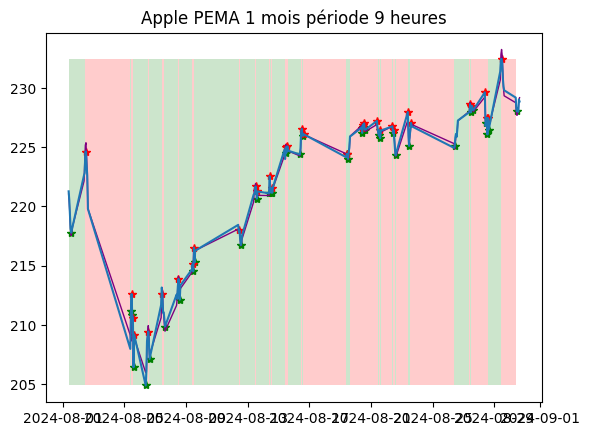

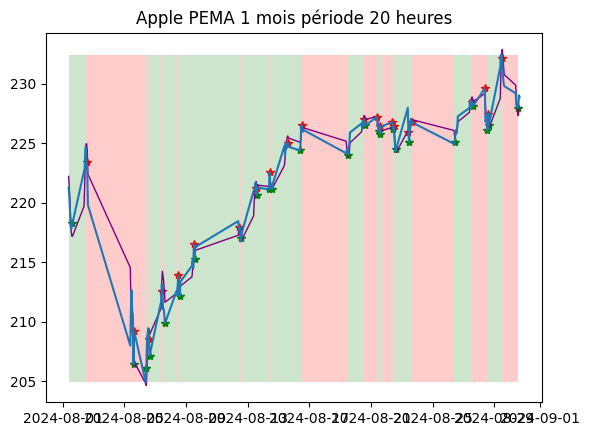

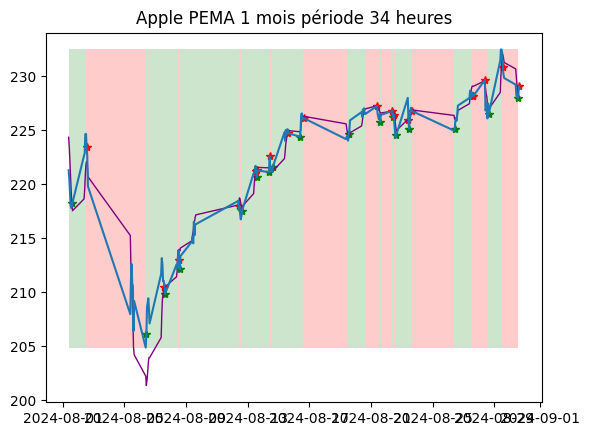

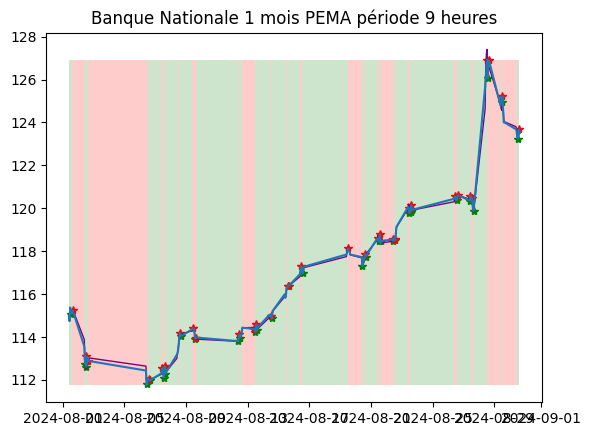

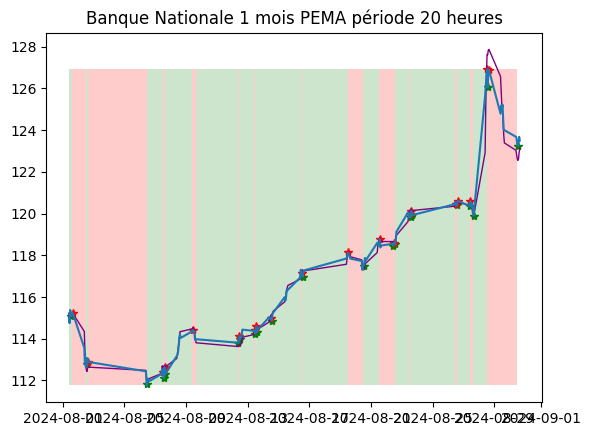

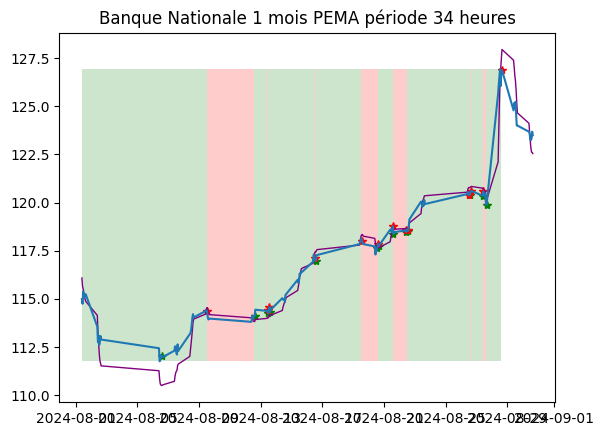

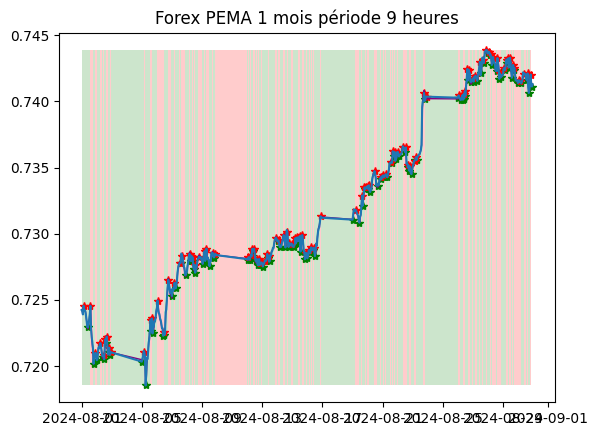

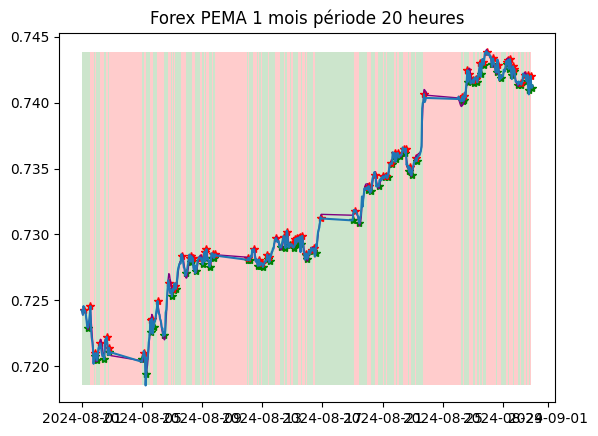

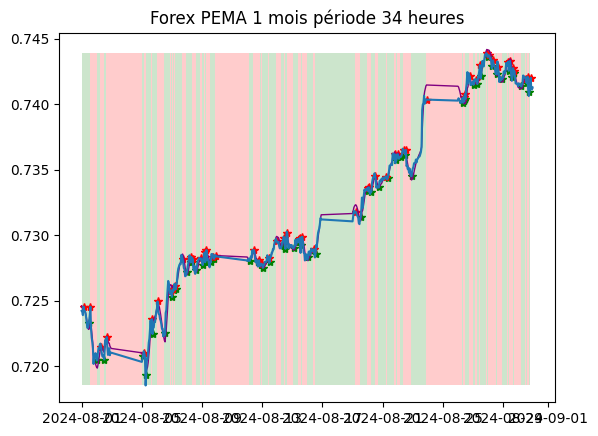

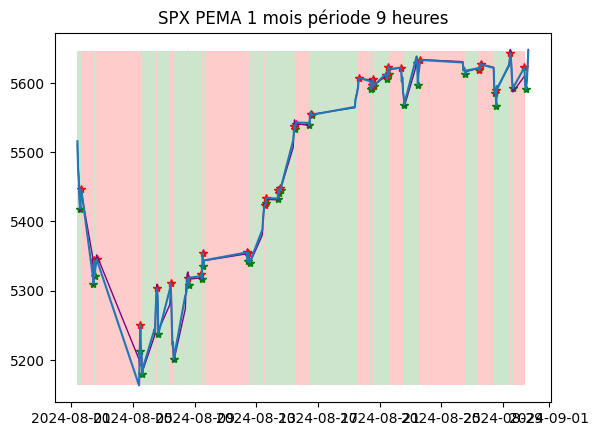

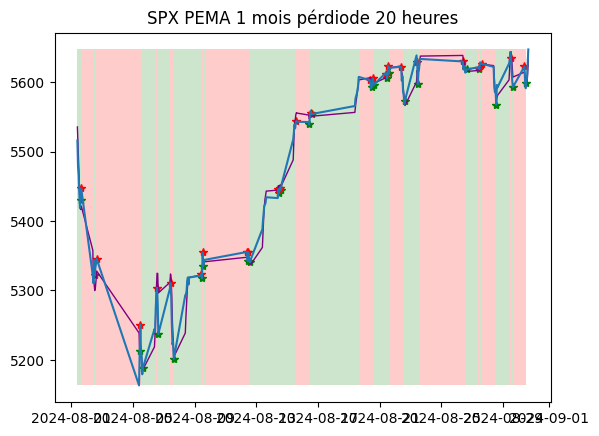

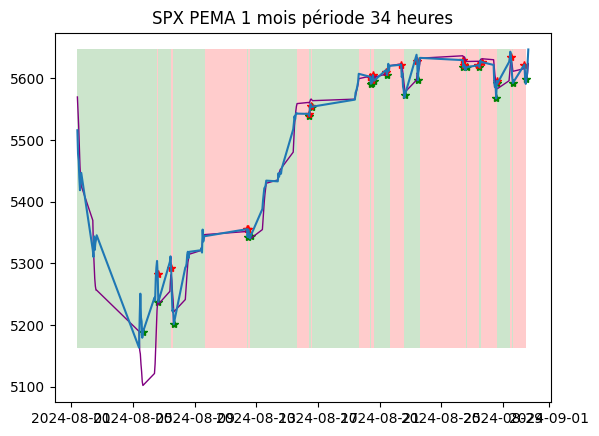

In [167]:
#1 mois
#Apple
daily_apple = yahooFinance.download("AAPL", start = datetime(2024,8,1), end = datetime(2024,9,1), interval = '1h')
daily_appleBeforePEMA = yahooFinance.download("AAPL", start = datetime(2024,7,10), end = datetime(2024,9,1), interval = '1h')

pemaResult(daily_apple, daily_appleBeforePEMA, 9, 'Apple PEMA 1 mois période 9 heures')
pemaResult(daily_apple, daily_appleBeforePEMA, 20, 'Apple PEMA 1 mois période 20 heures')
pemaResult(daily_apple, daily_appleBeforePEMA, 34, 'Apple PEMA 1 mois période 34 heures')

#BNO
daily_banqueNationale = yahooFinance.download("NA.TO", start = datetime(2024,8,1), end = datetime(2024,9,1), interval = '1h')
daily_banqueNationaleBefore = yahooFinance.download("NA.TO", start = datetime(2024,7,10), end = datetime(2024,9,1), interval = '1h')

pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 9, 'Banque Nationale 1 mois PEMA période 9 heures')
pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 20, 'Banque Nationale 1 mois PEMA période 20 heures')
pemaResult(daily_banqueNationale, daily_banqueNationaleBefore, 34, 'Banque Nationale 1 mois PEMA période 34 heures')

#FOREX
daily_cadusd = yahooFinance.download("CADUSD=X", start = datetime(2024,8,1), end = datetime(2024,9,1), interval = '1h')
daily_cadusdBefore = yahooFinance.download("CADUSD=X", start = datetime(2024,7,10), end = datetime(2024,9,1), interval = '1h')

pemaResult(daily_cadusd, daily_cadusdBefore, 9, 'Forex PEMA 1 mois période 9 heures')
pemaResult(daily_cadusd, daily_cadusdBefore, 20, 'Forex PEMA 1 mois période 20 heures')
pemaResult(daily_cadusd, daily_cadusdBefore, 34, 'Forex PEMA 1 mois période 34 heures')

#SP500
daily_sp500 = yahooFinance.download("^GSPC", start = datetime(2024,8,1), end = datetime(2024,9,1), interval = '1h')
daily_sp500Before = yahooFinance.download("^GSPC", start = datetime(2024,7,10), end = datetime(2024,9,1), interval = '1h')

pemaResult(daily_sp500, daily_sp500Before, 9, 'SPX PEMA 1 mois période 9 heures')
pemaResult(daily_sp500, daily_sp500Before, 20, 'SPX PEMA 1 mois pérdiode 20 heures')
pemaResult(daily_sp500, daily_sp500Before, 34, 'SPX PEMA 1 mois période 34 heures')
